# Ion stress response

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy
import matplotlib.pyplot as plt

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)
from ecolime.util.helper_functions import *
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(ecolime.__file__)

/home/jt/Downloads/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/Downloads/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/ecolime/__init__.py


In [2]:
gene_dictionary = pd.read_csv('gene_name_dictionary.csv',index_col=1)
ions = ['na1_e','ca2_e','zn2_e','k_e','mg2_e','mn2_e']

Load

In [3]:
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')

eco = cobra.io.load_json_model(eco_directory)
bsub = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)

bsub.optimize()
base = bsub.solution.x_dict
base_mu = bsub.solution.f

## M-model simulations

In [4]:
get_reactions_of_met(bsub,'na1_e')

( PIt7 0.0 999999.0 ) 	 3.0 na1_e + pi_e --> 3.0 na1_c + pi_c
( NAabcO 0.0 999999.0 ) 	 atp_c + h2o_c + na1_c --> adp_c + h_c + na1_e + pi_c
( GLUt4 0.0 999999.0 ) 	 glu__L_e + na1_e --> glu__L_c + na1_c
( NAt3_1 0.0 999999.0 ) 	 h_e + na1_c --> h_c + na1_e
( MALt4 0.0 999999.0 ) 	 mal__L_e + na1_e --> mal__L_c + na1_c
( BILEt4 0.0 999999.0 ) 	 bilea_e + na1_e --> bilea_c + na1_c
( EX_na1_e -999999.0 999999.0 ) 	 na1_e <=> 
( MALt10 0.0 999999.0 ) 	 2.0 h_e + lac__L_c + mal__L_e + na1_c --> 2.0 h_c + lac__L_e + mal__L_c + na1_e


[<Reaction PIt7 at 0x7faf867db668>,
 <Reaction NAabcO at 0x7faf867bdc88>,
 <Reaction GLUt4 at 0x7faf867f4ac8>,
 <Reaction NAt3_1 at 0x7faf867bdcf8>,
 <Reaction MALt4 at 0x7faf86827320>,
 <Reaction BILEt4 at 0x7faf87382198>,
 <Reaction EX_na1_e at 0x7faf873a37b8>,
 <Reaction MALt10 at 0x7faf868271d0>]

100%|██████████| 100/100 [00:08<00:00, 11.28it/s]


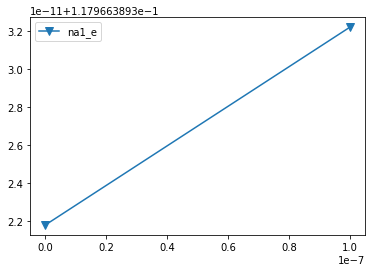

In [5]:
import itertools
marker = itertools.cycle(('v', 's', '^', 'o', '*')) 
ion_rates = -np.arange(0,10,0.1)*1e-6
for ion in ['na1_e']:
    base_flux = base['EX_'+ion]
    gr = []
    for rate in tqdm(ion_rates):
        ex = bsub.reactions.get_by_id('EX_'+ion)
        ex.lower_bound = rate
        ex.upper_bound = rate
        bsub.optimize()
        gr.append(bsub.solution.f)
    plt.plot(-ion_rates,gr,label=ion,marker=next(marker),markersize=8)
plt.legend()

## ME-model simulations

In [6]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [7]:
for ion in ions:
    print(ion, me.solution.x_dict['EX_'+ion])

na1_e 0.0
ca2_e 0.0
zn2_e -1.833244939576966e-07
k_e -1.8080572856545358e-07
mg2_e -0.0013002379702828882
mn2_e -2.3718242480067265e-06


Add those reactions that account for osmosis

In [8]:
# Add a copy of transport reactions that do not need a transporter

for ion in ions:
    uptake_rxns = get_transport_reactions(me,ion,comps=['e','c'],verbose=0)
    osm_rxns = []
    print('\n',ion)
    for rxn in uptake_rxns:
        stoich = rxn.stoichiometric_data.stoichiometry
        osm_id = rxn.id.split('_FWD')[0]+'_osm'

        if not hasattr(me.reactions,osm_id):
            osm_rxn = cobrame.MEReaction(osm_id)
            me.add_reaction(osm_rxn)

            osm_rxn.add_metabolites(stoich)
            osm_rxn.lower_bound=0
            osm_rxn.upper_bound=1000
            osm_rxns.append(osm_rxn)
            print(osm_rxn.id,osm_rxn.lower_bound,osm_rxn.upper_bound,osm_rxn.reaction)


 na1_e
MALt4_osm 0 1000 mal__L_e + na1_e <=> mal__L_c + na1_c
PIt7_osm 0 1000 3.0 na1_e + pi_e <=> 3.0 na1_c + pi_c
GLUt4_osm 0 1000 glu__L_e + na1_e <=> glu__L_c + na1_c
BILEt4_osm 0 1000 bilea_e + na1_e <=> bilea_c + na1_c

 ca2_e
CAt4_REV_CPLX8J2-142_osm 0 1000 ca2_c + h_e <=> ca2_e + h_c
CITt14_osm 0 1000 ca2_e + cit_e + h_e <=> ca2_c + cit_c + h_c
CAt4_REV_BSU07920-MONOMER_osm 0 1000 ca2_c + h_e <=> ca2_e + h_c

 zn2_e
ZNabc_osm 0 1000 atp_c + h2o_c + zn2_e <=> adp_c + h_c + pi_c + zn2_c
CITt15_osm 0 1000 cit_e + h_e + zn2_e <=> cit_c + h_c + zn2_c

 k_e
CD2t4_osm 0 1000 cd2_c + h_e + k_e <=> cd2_e + h_c + k_c
Kt1_osm 0 1000 k_e <=> k_c
ZN2t4_osm 0 1000 h_e + k_e + zn2_c <=> h_c + k_c + zn2_e
Kt2r_osm 0 1000 h_e + k_e <=> h_c + k_c

 mg2_e
CITt10_osm 0 1000 cit_e + h_e + mg2_e <=> cit_c + h_c + mg2_c
ICITt10_osm 0 1000 h_e + icit_e + mg2_e <=> h_c + icit_c + mg2_c
MGt5_REV_BSU08000-MONOMER_osm 0 1000 mg2_c <=> mg2_e
MGt5_REV_BSU24740-MONOMER_osm 0 1000 mg2_c <=> mg2_e
MGt5_REV_BS

Add ion uptake and exit separately

In [9]:
for ion in ions:
    
    old_ion = me.metabolites.get_by_id(ion)
    ion_base = ion.split('_')[0]
    # Close old exchange
    me.reactions.get_by_id('EX_{}'.format(ion)).lower_bound = 0
    me.reactions.get_by_id('EX_{}'.format(ion)).upper_bound = 0
    
    # Create new in/out metabolites
    ion_in = cobrame.Metabolite(id='{}_in'.format(ion_base))
    ion_out = cobrame.Metabolite(id='{}_out'.format(ion_base))
    
    # Ion uptake (creation, all open)
    rxn = cobrame.MEReaction(id='EX_{}_in'.format(ion_base))
    rxn.add_metabolites({
        ion_in:-1.0
    })
    me.add_reaction(rxn)
    rxn.lower_bound = -1000
    rxn.upper_bound = 0
    
    # Ion exit
    rxn = cobrame.MEReaction(id='DM_{}_out'.format(ion_base))
    rxn.add_metabolites({
        ion_out:-1.0
    })
    rxn.lower_bound = 0
    rxn.upper_bound = 1000
    me.add_reaction(rxn)
    
    # Replace old met
    uptake_rxns = get_reactions_of_met(me,ion,s = -1,verbose=0)
    exit_rxns = get_reactions_of_met(me,ion,s = 1,verbose=0)

    for rxn in uptake_rxns:
        coeff = rxn.pop(old_ion)
        rxn.add_metabolites({ion_in:coeff})
    for rxn in exit_rxns:
        coeff = rxn.pop(old_ion)
        rxn.add_metabolites({ion_out:coeff})
        #print('\n', ion)
    #_=get_reactions_of_met(me,ion_in.id)
    #_=get_reactions_of_met(me,ion_out.id)

In [10]:
def single_flux_response(me,rate,ion,mu_fix=False):
    ion_base = ion.split('_')[0]
    me.reactions.get_by_id('EX_{}_in'.format(ion_base)).lower_bound = rate
    me.reactions.get_by_id('EX_{}_in'.format(ion_base)).upper_bound = rate
    solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False,
                   precision = 1e-6,verbosity=0,mu_fix=mu_fix)
    return rate, me.solution.x_dict

In [11]:
# Calculation at several ion uptake rates
ion_rates_dict = {}
ion_fractions = np.arange(0,10)
for ion in ions:
    base_flux = me.solution.x_dict['EX_'+ion]
#     if base_flux:
#         ion_rates_dict[ion] = ion_fractions*base_flux
#     else:
    ion_rates_dict[ion] = ion_fractions*-0.2e-7
#ion_rates = -np.arange(0,10)*0.2e-7
print('Ions to include: {}'.format(ions))
print('Rates to use: {}'.format(ion_rates_dict))

ion_result_macrodict = dict()

import multiprocessing as mp
NP = min([len(ion_fractions),10])

Ions to include: ['na1_e', 'ca2_e', 'zn2_e', 'k_e', 'mg2_e', 'mn2_e']
Rates to use: {'na1_e': array([-0.0e+00, -2.0e-08, -4.0e-08, -6.0e-08, -8.0e-08, -1.0e-07,
       -1.2e-07, -1.4e-07, -1.6e-07, -1.8e-07]), 'ca2_e': array([-0.0e+00, -2.0e-08, -4.0e-08, -6.0e-08, -8.0e-08, -1.0e-07,
       -1.2e-07, -1.4e-07, -1.6e-07, -1.8e-07]), 'zn2_e': array([-0.0e+00, -2.0e-08, -4.0e-08, -6.0e-08, -8.0e-08, -1.0e-07,
       -1.2e-07, -1.4e-07, -1.6e-07, -1.8e-07]), 'k_e': array([-0.0e+00, -2.0e-08, -4.0e-08, -6.0e-08, -8.0e-08, -1.0e-07,
       -1.2e-07, -1.4e-07, -1.6e-07, -1.8e-07]), 'mg2_e': array([-0.0e+00, -2.0e-08, -4.0e-08, -6.0e-08, -8.0e-08, -1.0e-07,
       -1.2e-07, -1.4e-07, -1.6e-07, -1.8e-07]), 'mn2_e': array([-0.0e+00, -2.0e-08, -4.0e-08, -6.0e-08, -8.0e-08, -1.0e-07,
       -1.2e-07, -1.4e-07, -1.6e-07, -1.8e-07])}


In [12]:
# Parallel processing
pbar = tqdm(total=len(ions)*len(ion_fractions))
for ion in ions:
    flux_dict = {}  
    ion_rates = ion_rates_dict[ion]
    pbar.set_description('Calculating {} ({} threads)'.format(ion,NP))
    def collect_result(result):
        pbar.update(1)
        flux_dict[result[0]] = result[1]
        
    pool = mp.Pool(NP)
    for rate in ion_rates:
        pool.apply_async(single_flux_response, args=(me,rate,ion), callback=collect_result)
    pool.close()
    pool.join()
    ion_result_macrodict[ion] = flux_dict
    flux_responses_me = pd.DataFrame.from_dict(flux_dict)
    flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
    flux_responses_me.to_csv('{}_flux_responses.csv'.format(ion))

Calculating mn2_e (10 threads):  78%|███████▊  | 47/60 [1:44:53<13:01, 60.10s/it]   

KeyError: 'EX_mg2_in'

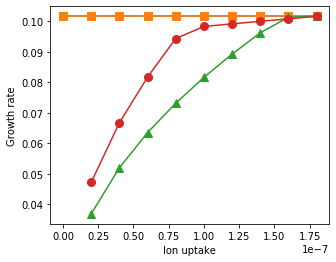

In [13]:
import itertools
marker = itertools.cycle(('v', 's', '^', 'o', '*')) 

plt.figure(figsize=(5,4))
for idx,ion in enumerate(ions):
    ion_base = ion.split('_')[0]
    flux_responses_me = pd.DataFrame.from_dict(ion_result_macrodict[ion])
    flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]

    plt.plot((-flux_responses_me.loc['EX_{}_in'.format(ion_base)]),flux_responses_me.loc['biomass_dilution'],
                label = ion,marker = next(marker),markersize=8)
    plt.xlabel('Ion uptake')
    plt.ylabel('Growth rate')
plt.legend()
plt.tight_layout()

In [ ]:
flux_responses_me

It appers that the icnrease davailability of ionstends to favor growth for Na and Ca. Zn does not change much. Potassium seems to greatly decrease. Is it due to the transporter expression?

In [ ]:
plt.figure(figsize=(10,5))
marker = itertools.cycle(('v', 's', '^', 'o', '*')) 
for idx,ion in enumerate(ions):
    ion_base = ion.split('_')[0]
    plt.subplot(2,3,idx+1)
    flux_responses_me = pd.DataFrame.from_dict(ion_result_macrodict[ion])
    flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
    
    uptake_rxns = get_transport_reactions(me,ion.replace('e','c'),comps=['in','c'],verbose=0)
    exit_rxns = get_transport_reactions(me,ion.replace('e','c'),comps=['c','out'],verbose=0)
    transport_rxns = uptake_rxns + exit_rxns
    for rxn in exit_rxns:
        if not hasattr(rxn,'complex_data'):
            continue
        
        complex_id = rxn.complex_data.complex.id
        formation_id = 'formation_{}'.format(complex_id)
        plt.plot(-flux_responses_me.loc['EX_{}_in'.format(ion_base)],
                 flux_responses_me.loc[formation_id]/flux_responses_me.loc['biomass_dilution'],
                 label = complex_id,marker = next(marker),markersize=8)
    plt.xlabel('Ion uptake')
    plt.title(ion)
    #plt.legend()
plt.tight_layout()

In [ ]:
ion = 'k_c'
flux_responses_me = pd.DataFrame.from_dict(ion_result_macrodict[ion])
flux_responses_me = flux_responses_me[sorted(flux_responses_me.columns)]
transport_rxns = get_reactions_of_met(me,ion.replace('_c','_e'),verbose=0)
for rxn in transport_rxns:
    if not hasattr(rxn,'complex_data'):
        continue
    complex_id = rxn.complex_data.complex.id
    formation_id = 'formation_{}'.format(complex_id)
    
    plt.plot(-flux_responses_me.loc['EX_{}_osm'.format(ion)],flux_responses_me.loc[formation_id],
                label = formation_id)
    plt.xlabel('Ion uptake')
plt.legend(bbox_to_anchor=(1, 1))

In [ ]:
rxn

In [ ]:
# Visualize protein expression profiles
plt.figure(figsize=(15,4))
import itertools
marker = itertools.cycle(('v', 's', '^', 'o', '*')) 

flux_responses_me[abs(flux_responses_me)<1e-20] = 0

plt.figure(figsize=(12,4))
plt.subplots_adjust(wspace=0.3)
plt.subplot(1,2,1)
genes = ['ktrB','ktrA']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_k_c_osm'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title('Protein: K+ transporter KtrAB')

plt.subplot(1,2,2)
genes = ['ktrB','ktrA']
for gene_name,locus_id in gene_dictionary.loc[genes]['locus_id'].items():
    expression = flux_responses_me.loc['translation_'+locus_id]
    expression /= np.max(expression)
    plt.plot(-flux_responses_me.loc['EX_k_c_osm'],expression,
            label=gene_name,marker = next(marker),markersize=8)
plt.legend()
plt.xlabel('Sodium uptake')
plt.ylabel('Protein expression')
plt.title(genes)